# **Finite difference method for barrier option**

Suppose we consider the pricing of an down-and-in barrier put option which payoff is $(K-S_T)^{+}1_{(L_T \le B_{ki})}$ where $L_t:=\inf_{0\le u\leq t}S_t$ represents the running minimum of the stock price up to time $t$, and $B_{ki}$ is the knock-in level of the option. To conveniently price this option, we utilise the "in-out parity":

\begin{align}
(K-S_T)^{+} = (K-S_T)^{+}1_{(L_T \le B_{ki})} + (K-S_T)^{+}1_{(L_T > B_{ko})}
\end{align}


From this, the knock-in barrier option price can be deduced via the knock-out barrier option price, whose payoff is $(K-S_T)^{+}1_{(L_T > B_{ko})}$, where $B_{ki}=B_{ko}$.

Then under the Black-Scholes model, the PDE is

\begin{align}
&\frac{\partial V}{\partial t}=\frac{\sigma^2 s^2}{2}\frac{\partial^2 V}{\partial s^2} + rs\frac{\partial V}{\partial s} -rV,& t>0 \\
&V(t,B_{ko})=0,&t>0\\
&V(0,s)=(K-s)^{+}\mathbb{1}_{\{ s>B_{ko}\}},& t=0
\end{align}

(Assuming that the time direction has already been reversed such that we work with a PDE with initial condition)

The only difference relative to the PDE for pricing a simple European put option is that have to include a new boundary condition $V(t,B_{ko})=0$. It refers to the fact that the value of the option must be zero once the stock price touches the knock-out level.


# *Fully implicit method for solving the PDE*

We are implementing a fully implicit method to solve the PDE and wrap the pricer in a standalone function. To begin with, we load some standard packages and the Thomas Algorithm solver.

In [ ]:
import numpy as np
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt

# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

We are interested in solving for the option price $V(t,s)$ over the domain $[0,T]\times [B_{ko},s_{max}]$. There is no need to solve for the option price for $s<B_{ko}$ because by definition of the product the option will have been knocked out and thus its value is zero.

Now we wrap the implicit scheme in a function. Recall the iterative step for a fully implicit scheme is given by
\begin{align}
(\mathbb{I}-L)V^{n}=G^n(V^{n-1})
\end{align}
where $G^n(\cdot)$ is the boundary condition operator applied on a vector, $L$ is some matrix we have defined before associated with the Black-Scholes PDE, and $\mathbb{I}$ is an identity matrix. At each time step given $V^{n-1}$, $V^n$ is obtained by solving a system of equations with the Thomas algorithm.

The whole procedure is the same as that of the pricing of a simple European option. The only change is the new boundary condition where we require $V(t,B_{ko})=0$ for any $t$. We expect $V(t,s_{max})=0$ because a put option is involved.

In [ ]:
def DownOutBarrierPutOptionImplicit(K, r, sigma, T, s_min, s_max, B_ko, N, M):

    # Setup of grids
    dt = T/N
    dx = (s_max - s_min)/M
    s = np.linspace(s_min, s_max, M+1)
    t = np.linspace(0, T, N+1)
    B_grid_number = int((B_ko - s_min) // dx)
    s = s[B_grid_number:]

    # Set up the vectors A, B and C
    A = 0.5 * sigma**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
    B = - sigma**2 * dt / dx**2 * s**2 - r * dt
    C = 0.5 * sigma**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

    # Setup the matrix L and I
    a_diag = np.concatenate([A[1:-1],[0]])
    b_diag = np.concatenate([[0],B[1:-1],[0]])
    c_diag = np.concatenate([[0],C[1:-1]])
    L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
    I = np.identity(M+1)

    # Running the implicit scheme

    # Initial condition
    v_im = np.maximum(K - s, 0) # no need to consider multiplication with the indicator function because only consider $s<B_ko$

    # Iteration of implicit scheme
    for n in range(1, N+1):

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = 0   # Boundary operator at s=s_min=B_ko
        d[-1] = 0  # !! Boundary operator at s=s_max=0 
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

    v_im = np.concatenate([np.zeros(B_grid_number), v_im], axis = 0)
    s = np.linspace(s_min, s_max, M+1)

    return v_im, s

# *Plot of the results*

We display the pricing function for the down-and-out barrier put option with different knock-out levels.

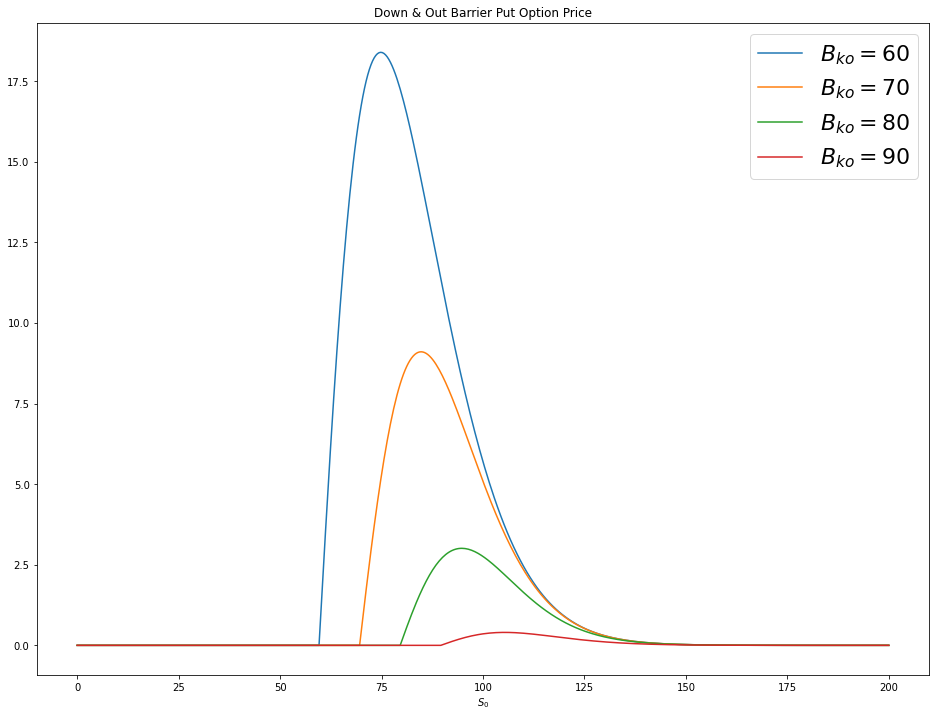

In [ ]:
# Market and option parameters
K, r, sigma, T = 100, 0.01, 0.157, 1
s_min, s_max = 0, 200
N, M = 1000, 500

# List of option's knock-out levels
B_all = [60, 70, 80, 90]

fig, ax = plt.subplots(figsize=(16,12))

for B_ko in B_all:
    v_do, s = DownOutBarrierPutOptionImplicit(K, r, sigma, T, s_min, s_max, B_ko, N, M)
    ax.plot(s, v_do, '-', label='$B_{ko}='+str(B_ko)+'$')

ax.set_title("Down & Out Barrier Put Option Price")
ax.set_xlabel("$S_0$")
ax.legend(fontsize=22)

In [ ]:
def EuropeanPutOptionImplicit(K, r, sigma, T, s_min, s_max, N, M):

    # Setup of grids
    dt = T/N
    dx = (s_max - s_min)/M
    s = np.linspace(s_min, s_max, M+1)
    t = np.linspace(0, T, N+1)

    # Set up the vectors A, B and C
    A = 0.5 * sigma**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
    B = - sigma**2 * dt / dx**2 * s**2 - r * dt
    C = 0.5 * sigma**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

    # Setup the matrix L and I
    a_diag = np.concatenate([A[1:-1],[0]])
    b_diag = np.concatenate([[0],B[1:-1],[0]])
    c_diag = np.concatenate([[0],C[1:-1]])
    L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
    I = np.identity(M+1)

    # Running the implicit scheme

    # Initial condition
    v_im = np.maximum(K - s, 0) 

    # Iteration of implicit scheme
    for n in range(1, N+1):
    
        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = K*np.exp(-r*t[n]) - s_min   # Boundary operator at s=s_min
        d[M] = 0  # !! Boundary operator at s=s_max 
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

    return v_im, s

No handles with labels found to put in legend.


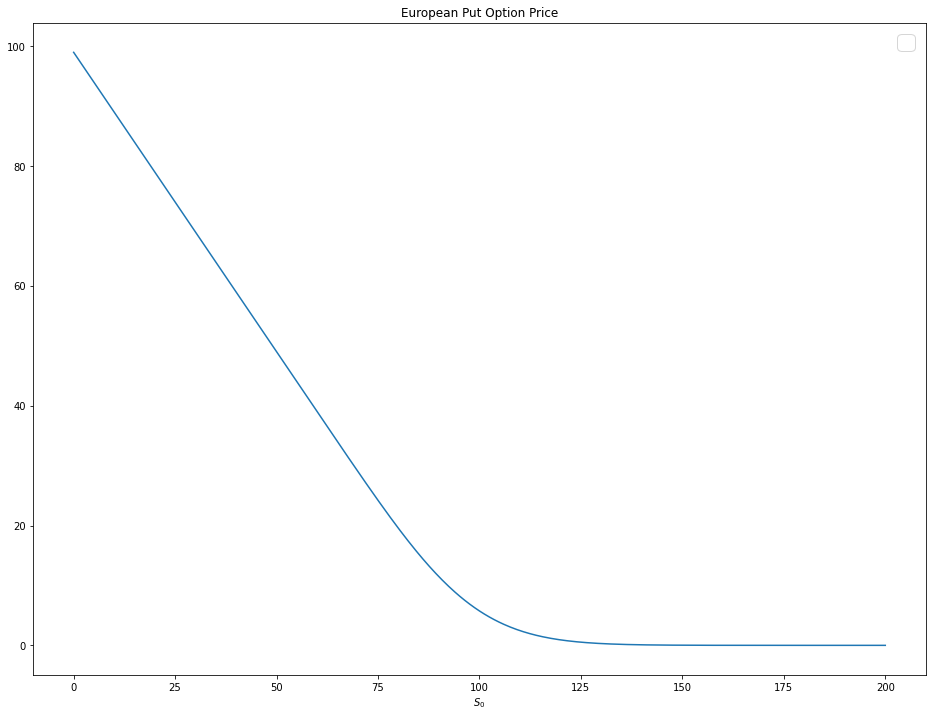

In [ ]:
# Market and option parameters
K, r, sigma, T = 100, 0.01, 0.157, 1
s_min, s_max = 0, 200
N, M = 1000, 500

v_eu, s = EuropeanPutOptionImplicit(K, r, sigma, T, s_min, s_max, N, M)

fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, v_eu)
ax.set_title("European Put Option Price")
ax.set_xlabel("$S_0$")
ax.legend(fontsize= 22)

0.04179735775117699
0.6521712234536308
2.9825644385777452
5.383081167559275


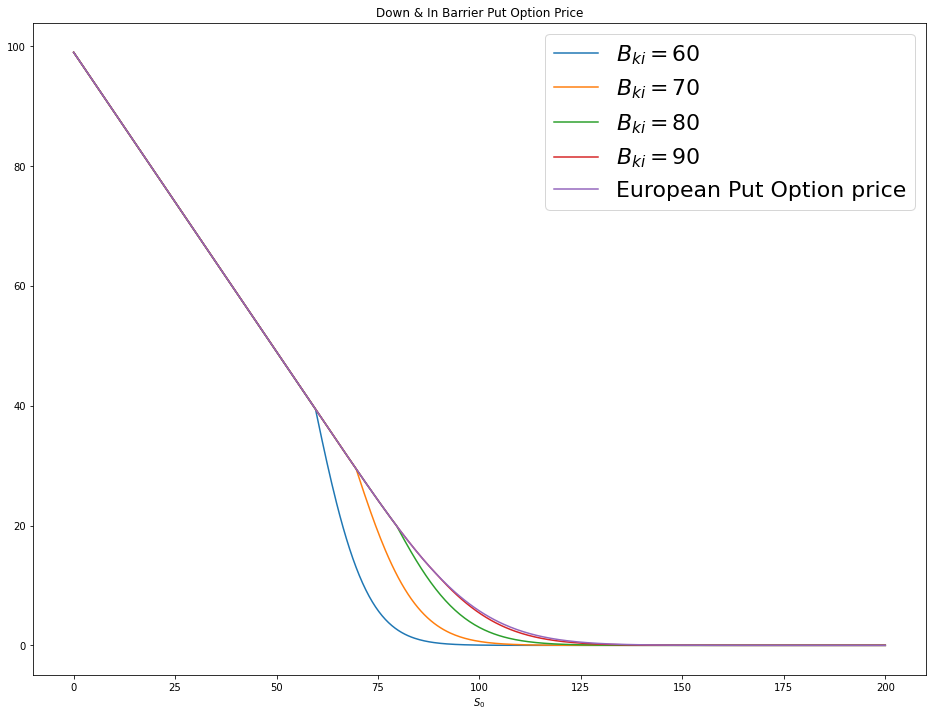

In [ ]:
# Market and option parameters
K, r, sigma, T = 100, 0.01, 0.157, 1
s_min, s_max = 0, 200
N, M = 1000, 500

# List of option's knock-out levels
B_all = [60, 70, 80, 90]

v_eu, s = EuropeanPutOptionImplicit(K, r, sigma, T, s_min, s_max, N, M)

fig, ax = plt.subplots(figsize=(16,12))

for B_ko in B_all:
    v_do, _ = DownOutBarrierPutOptionImplicit(K, r, sigma, T, s_min, s_max, B_ko, N, M)
    v_di = v_eu - v_do
    print(v_di[list(s).index(100.)])
    ax.plot(s, v_di, '-', label='$B_{ki}='+str(B_ko)+'$')

ax.plot(s, v_eu, label = "European Put Option price")
ax.set_title("Down & In Barrier Put Option Price")
ax.set_xlabel("$S_0$")
ax.legend(fontsize=22)

Now we price the above option with local volatility model rather than constant volatility $\sigma = 15.7\%$.

In [ ]:
def EuropeanPutOptionImplicitlocal(K, r, T, s_min, s_max, N, M):
    
    # Setup of grids
    dt = T/N
    dx = (s_max - s_min)/M
    s = np.linspace(s_min, s_max, M+1)
    t = np.linspace(0, T, N+1)

    sigma = np.zeros((len(t), len(s)))
    for i in range(len(t)):
      for j in range(len(s)):
        sigma[i][j] = (1 + (T - t[i])/30)*(0.1 + 0.4 * np.exp(-s[j]/50))

    # Initial condition
    v_im = np.maximum(K - s, 0)

    # Iteration of implicit scheme
    for n in range(1,N+1):

      # Set up the vectors A, B and C
      A = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
      B = - sigma[n]**2 * dt / dx**2 * s**2 - r * dt
      C = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

      # Setup the matrix L and I
      a_diag = np.concatenate([A[1:-1],[0]])
      b_diag = np.concatenate([[0],B[1:-1],[0]])
      c_diag = np.concatenate([[0],C[1:-1]])

      d = v_im   # The RHS of the system of equations is V^{n-1}
      d[0] = K*np.exp(-r*t[n]) - s_min   # Boundary operator at s_min
      d[M] = 0  # Boundary operator at s_max
      v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

    return v_im, s

No handles with labels found to put in legend.


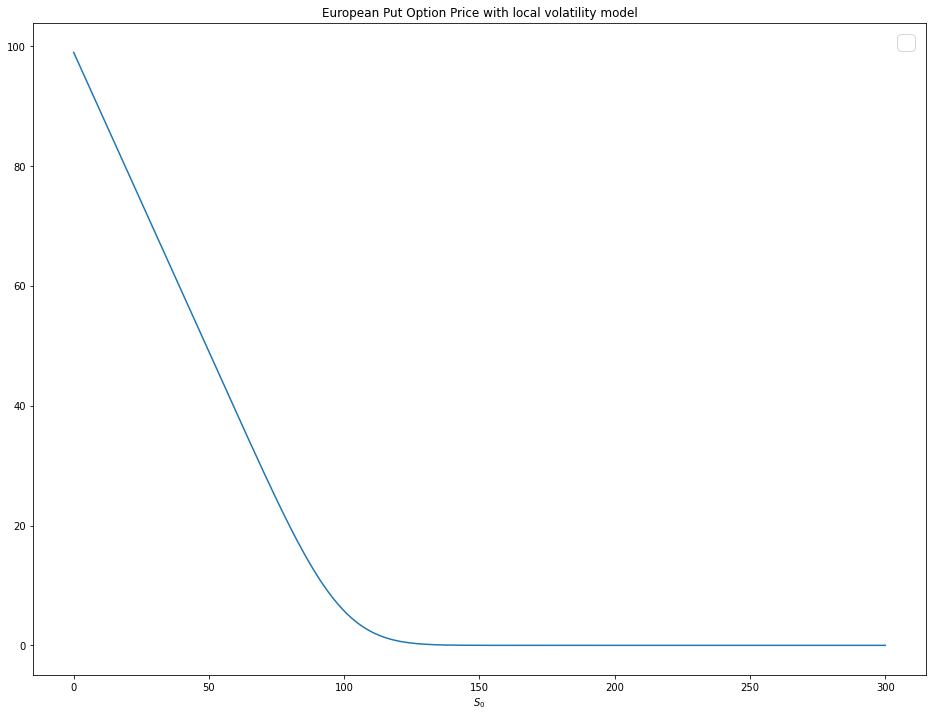

In [ ]:
# Market and option parameters
K, r, T = 100, 0.01, 1
s_min, s_max = 0, 300
N, M = 1000, 500

v_eu_local, s = EuropeanPutOptionImplicitlocal(K, r, T, s_min, s_max, N, M)

fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, v_eu_local)
ax.set_title("European Put Option Price with local volatility model")
ax.set_xlabel("$S_0$")
ax.legend(fontsize= 22)

In [ ]:
def DownOutBarrierPutOptionImplicitlocal(K, r, T, s_min, s_max, B_ko, N, M):

    # Setup of grids
    dt = T/N
    dx = (s_max - s_min)/M
    s = np.linspace(s_min, s_max, M+1)
    t = np.linspace(0, T, N+1)
    B_grid_number = int((B_ko - s_min) // dx)
    s = s[B_grid_number:]

    sigma = np.zeros((len(t), len(s)))
    for i in range(len(t)):
      for j in range(len(s)):
        sigma[i][j] = (1 + (T - t[i])/30)*(0.1 + 0.4 * np.exp(-s[j]/50))


    # Running the implicit scheme

    # Initial condition
    v_im = np.maximum(K - s, 0) # no need to consider multiplication with the indicator function because only consider $s<B_ko$

    # Iteration of implicit scheme
    for n in range(1, N+1):

        A = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
        B = - sigma[n]**2 * dt / dx**2 * s**2 - r * dt
        C = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

        # Setup the matrix L and I
        a_diag = np.concatenate([A[1:-1],[0]])
        b_diag = np.concatenate([[0],B[1:-1],[0]])
        c_diag = np.concatenate([[0],C[1:-1]])
        L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
        I = np.identity(M+1)

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = 0   # Boundary operator at s=s_min=B_ko
        d[-1] = 0  # !! Boundary operator at s=s_max=0 
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

    v_im = np.concatenate([np.zeros(B_grid_number), v_im], axis = 0)
    s = np.linspace(s_min, s_max, M+1)

    return v_im, s

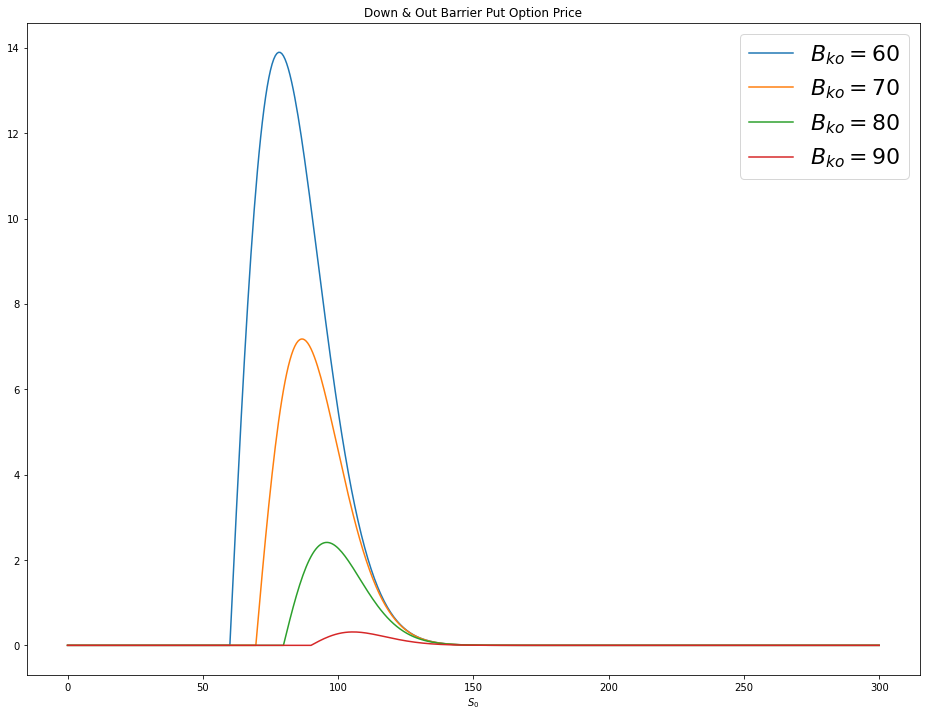

In [ ]:
# Market and option parameters
K, r, T = 100, 0.01, 1
s_min, s_max = 0, 300
N, M = 1000, 500

# List of option's knock-out levels
B_all = [60, 70, 80, 90]

fig, ax = plt.subplots(figsize=(16,12))

for B_ko in B_all:
    v_do_local, s = DownOutBarrierPutOptionImplicitlocal(K, r, T, s_min, s_max, B_ko, N, M)
    ax.plot(s, v_do_local, '-', label='$B_{ko}='+str(B_ko)+'$')

ax.set_title("Down & Out Barrier Put Option Price")
ax.set_xlabel("$S_0$")
ax.legend(fontsize=22)

0.21215697157997404
1.1631421148779726
3.4044289718152645
5.4204799970778055


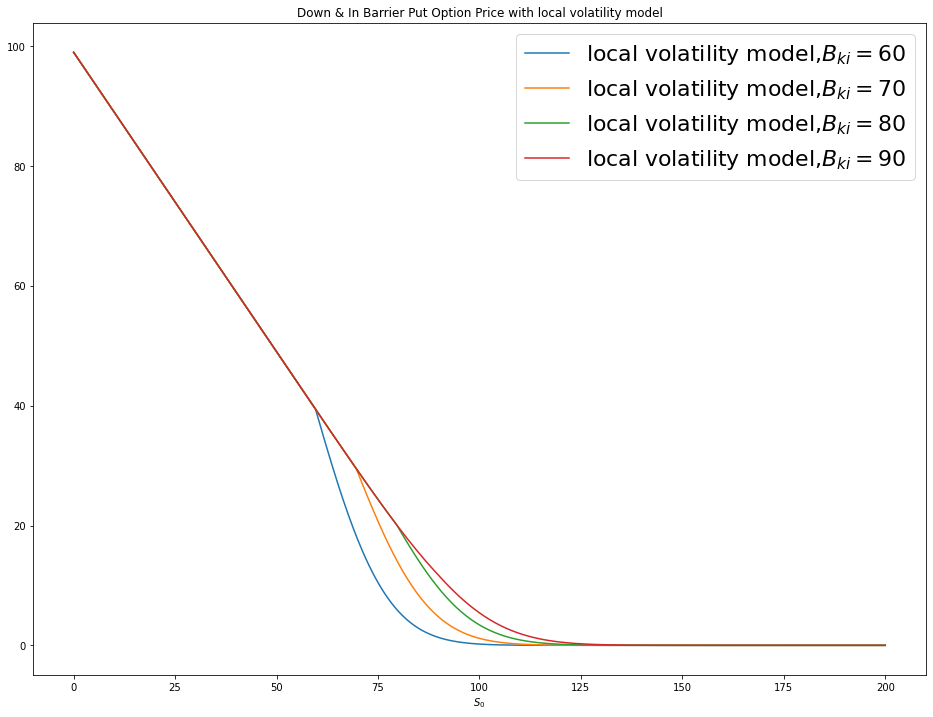

In [ ]:
# Market and option parameters
K, r, T = 100, 0.01, 1
s_min, s_max = 0, 200
N, M = 1000, 500

# List of option's knock-out levels
B_all = [60, 70, 80, 90]

v_eu_local, s = EuropeanPutOptionImplicitlocal(K, r, T, s_min, s_max, N, M)

fig, ax = plt.subplots(figsize=(16,12))

for B_ko in B_all:
    v_do_local, _ = DownOutBarrierPutOptionImplicitlocal(K, r, T, s_min, s_max, B_ko, N, M)
    v_di_local = v_eu_local - v_do_local
    print(v_di_local[list(s).index(100.)])
    ax.plot(s, v_di_local, '-', label='local volatility model,$B_{ki}='+str(B_ko)+'$')

#ax.plot(s, v_eu, label = "European Put Option price with local volatility model")
ax.set_title("Down & In Barrier Put Option Price with local volatility model")
ax.set_xlabel("$S_0$")
ax.legend(fontsize=22)